In [1]:
import sys, os
import matplotlib.pyplot as plt
sys.path.append("../")
from sklearn.metrics import mean_squared_error
import re

In [2]:
distances=[2,4,10,20,25,35]
saved_models = '/storage/yw18581/src/leaf_reco/saved_models/trained_6positions/'

In [3]:
# Parameters
distance = [2, 4, 10, 20, 25, 35]
saved_models = "/storage/yw18581/src/leaf_reco/saved_models/trained_6positions/"


In [4]:
import numpy as np

In [5]:
regex = re.compile(r'\d+')

In [6]:
%matplotlib inline

In [7]:
from setenv import add_folders

In [8]:
add_folders(key="deepthought")

In [9]:
from utility_functions import define_dataset, training_phase_rUNet, inference_phase_rUNet, exclude_dist, inference_phase_rUNet_plot_notebook

In [10]:
from cUNet_pytorch_pooling import cUNet

In [11]:
import torch

In [12]:
DATA_DIR_DEEPTHOUGHT = "/storage/yw18581/data"

In [13]:
data_dir = DATA_DIR_DEEPTHOUGHT

In [14]:
root_folder = os.path.join(data_dir, "dataset")

In [15]:
excluded = exclude_dist(dist_list=distances, root_folder=root_folder)

In [16]:
excluded

['10x10_2mm_second_clean',
 '10x10_2mm_third_clean',
 '10x10_2mm_first_clean',
 '10x10_2mm_first',
 '10x10_2mm_second',
 '10x10_2mm_third',
 '10x10_4mm_second_clean',
 '10x10_4mm_third_clean',
 '10x10_4mm_first_clean',
 '10x10_4mm_first',
 '10x10_4mm_second',
 '10x10_4mm_third',
 '10x10_10mm_second_clean',
 '10x10_10mm_third_clean',
 '10x10_10mm_first_clean',
 '10x10_10mm_first',
 '10x10_10mm_second',
 '10x10_10mm_third',
 '10x10_20mm_second_clean',
 '10x10_20mm_third_clean',
 '10x10_20mm_first_clean',
 '10x10_20mm_first',
 '10x10_20mm_second',
 '10x10_20mm_third',
 '10x10_25mm_second_clean',
 '10x10_25mm_third_clean',
 '10x10_25mm_first_clean',
 '10x10_25mm_first',
 '10x10_25mm_second',
 '10x10_25mm_third',
 '10x10_35mm_second_clean',
 '10x10_35mm_third_clean',
 '10x10_35mm_first_clean',
 '10x10_35mm_first',
 '10x10_35mm_second',
 '10x10_35mm_third']

In [17]:
data_loaders, data_lengths= define_dataset(root_folder, batch_size=16, excluded_list=excluded, alldata=True)

In [18]:
data_lengths

3532

In [19]:
model_names = os.listdir(saved_models)

In [20]:
model_names

['Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_35epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_40epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_45epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_50epochs_0.75coeff_mask.pkl',
 'history_Trained_rUNet_pytorch_50epochs_0.75coef.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_5epochs_0.7coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.7coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.7coeff_mask.pkl',


In [21]:
def get_fnames(key):
    f_list = []
    epochs = []
    for fname in model_names:
        if fname.startswith("Trained"):
            if regex.findall(fname.split("_")[6])[1]==str(key):
                f_list.append(fname)
                epochs.append(int(regex.findall(fname.split("_")[5])[0]))
    return f_list, epochs

In [22]:
get_fnames(75)

(['Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_35epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_40epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_45epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_50epochs_0.75coeff_mask.pkl'],
 [5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [23]:
def mse_vs_epochs(coeff):
    mse = []
    f_list, epochs = get_fnames(coeff)
    for fname, e in zip(f_list, epochs):
        print(fname, e)
        torch.cuda.empty_cache()
        model= cUNet(out_size=1)
        checkpoint = torch.load(os.path.join(saved_models, fname))['model_state_dict'];
        model.load_state_dict(checkpoint)
        y_true, y_pred = inference_phase_rUNet(model, data_loaders, data_lengths, batch_size=16,
                                               notebook=True, test=False)
        np.savez_compressed(os.path.join(saved_models, '_'.join(['predicted',
                                                                 'unseen',
                                                                 fname.split('_')[3],
                                                                 fname.split('_')[5],
                                                                 fname.split('_')[6]])
                                         +'.npz'), true=y_true, pred=y_pred)
        mse.append(mean_squared_error(y_true, y_pred))
        
    plt.plot(epochs, mse)
    return mse, epochs

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl 30



Trained_rUNet_pytorch_6positions_dataset_35epochs_0.75coeff_mask.pkl 35



Trained_rUNet_pytorch_6positions_dataset_40epochs_0.75coeff_mask.pkl 40



Trained_rUNet_pytorch_6positions_dataset_45epochs_0.75coeff_mask.pkl 45



Trained_rUNet_pytorch_6positions_dataset_50epochs_0.75coeff_mask.pkl 50


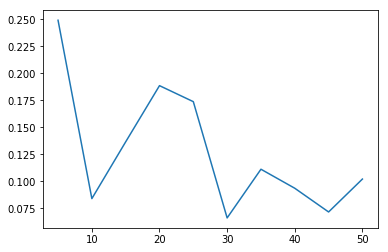

In [24]:
mse075, epochs = mse_vs_epochs(75)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.7coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.7coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.7coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.7coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.7coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.7coeff_mask.pkl 30



Trained_rUNet_pytorch_6positions_dataset_35epochs_0.7coeff_mask.pkl 35



Trained_rUNet_pytorch_6positions_dataset_40epochs_0.7coeff_mask.pkl 40



Trained_rUNet_pytorch_6positions_dataset_45epochs_0.7coeff_mask.pkl 45



Trained_rUNet_pytorch_6positions_dataset_50epochs_0.7coeff_mask.pkl 50


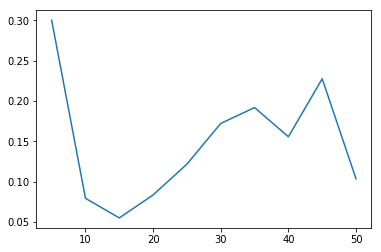

In [25]:
mse070, epochs = mse_vs_epochs(7)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.6coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.6coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.6coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.6coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.6coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.6coeff_mask.pkl 30



Trained_rUNet_pytorch_6positions_dataset_35epochs_0.6coeff_mask.pkl 35



Trained_rUNet_pytorch_6positions_dataset_40epochs_0.6coeff_mask.pkl 40



Trained_rUNet_pytorch_6positions_dataset_45epochs_0.6coeff_mask.pkl 45



Trained_rUNet_pytorch_6positions_dataset_50epochs_0.6coeff_mask.pkl 50


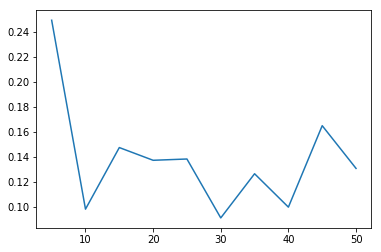

In [26]:
mse060, epochs = mse_vs_epochs(6)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.5coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.5coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.5coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.5coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.5coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.5coeff_mask.pkl 30



Trained_rUNet_pytorch_6positions_dataset_35epochs_0.5coeff_mask.pkl 35



Trained_rUNet_pytorch_6positions_dataset_40epochs_0.5coeff_mask.pkl 40



Trained_rUNet_pytorch_6positions_dataset_45epochs_0.5coeff_mask.pkl 45



Trained_rUNet_pytorch_6positions_dataset_50epochs_0.5coeff_mask.pkl 50


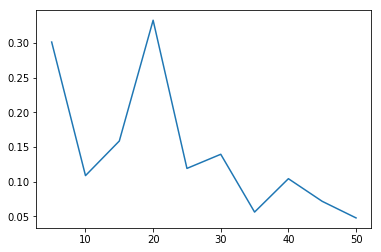

In [27]:
mse050, epochs = mse_vs_epochs(5)

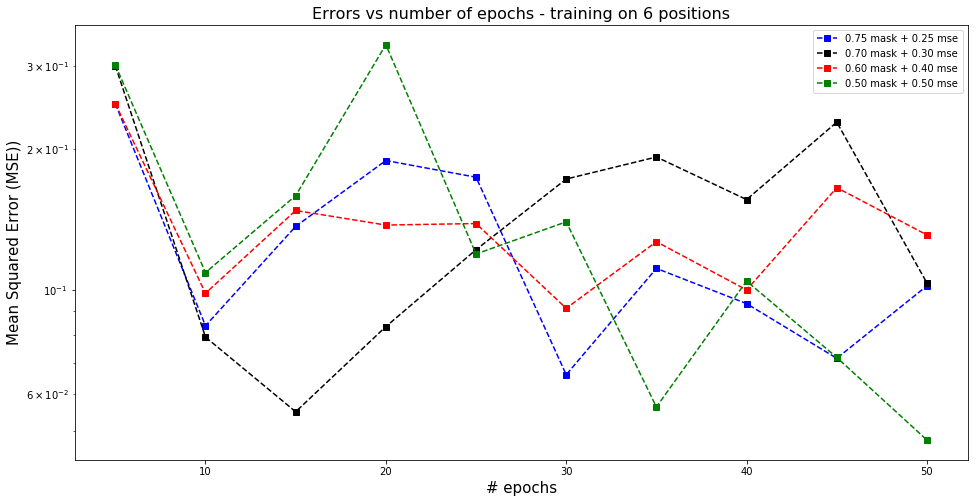

In [28]:
fig1, ax1 = plt.subplots(figsize=(16,8))
plt.title("Errors vs number of epochs - training on 6 positions",size=16)
ax1.plot(epochs, mse075, 's--', linewidth=1.5, c='blue',label='0.75 mask + 0.25 mse')
ax1.plot(epochs, mse070,'s--', linewidth=1.5, c='k', label='0.70 mask + 0.30 mse')
ax1.plot(epochs, mse060, 's--', linewidth=1.5, c='red', label='0.60 mask + 0.40 mse')
ax1.plot(epochs, mse050, 's--', linewidth=1.5, c='green', label='0.50 mask + 0.50 mse')
#ax1.plot(epochs, errors_250_4, 's--', linewidth=1.5, c='magenta', label='250 epochs_unseen')
#ax1.plot(epochs, errors_300_4, 's--', linewidth=1.5, c='orange', label='300 epochs_unseen')

ax1.set_ylabel("Mean Squared Error (MSE))", size=15)
#ax1.set_xticks(np.arange(1,36,1))#[1,2,3,4,10,15,20,25,30,35])
ax1.set_xlabel("# epochs", size=15)
ax1.set_yscale('log')
ax1.legend(loc='upper right')
plt.show()

In [29]:
data_loaders_mask, data_lengths_mask = define_dataset(root_folder, batch_size=2, excluded_list=excluded)

In [30]:
def masks_vs_epochs(coeff):
    f_list, epochs = get_fnames(coeff)
    for fname, e in zip(f_list, epochs):
        print(fname, e)
        torch.cuda.empty_cache()
        model= cUNet(out_size=1)
        checkpoint = torch.load(os.path.join(saved_models, 
                                                      fname))['model_state_dict'];
        model.load_state_dict(checkpoint)
        inference_phase_rUNet_plot_notebook(model, data_loaders_mask, data_lengths_mask, batch_size=2,
                                               stop=1, test=False)
    return 

In [31]:
masks_vs_epochs(75)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl 5
Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl 10
Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl 15
Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl 20
Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl 25
Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl 30
Trained_rUNet_pytorch_6positions_dataset_35epochs_0.75coeff_mask.pkl 35
Trained_rUNet_pytorch_6positions_dataset_40epochs_0.75coeff_mask.pkl 40
Trained_rUNet_pytorch_6positions_dataset_45epochs_0.75coeff_mask.pkl 45
Trained_rUNet_pytorch_6positions_dataset_50epochs_0.75coeff_mask.pkl 50


In [32]:
masks_vs_epochs(7)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.7coeff_mask.pkl 5
Trained_rUNet_pytorch_6positions_dataset_10epochs_0.7coeff_mask.pkl 10
Trained_rUNet_pytorch_6positions_dataset_15epochs_0.7coeff_mask.pkl 15
Trained_rUNet_pytorch_6positions_dataset_20epochs_0.7coeff_mask.pkl 20
Trained_rUNet_pytorch_6positions_dataset_25epochs_0.7coeff_mask.pkl 25
Trained_rUNet_pytorch_6positions_dataset_30epochs_0.7coeff_mask.pkl 30
Trained_rUNet_pytorch_6positions_dataset_35epochs_0.7coeff_mask.pkl 35
Trained_rUNet_pytorch_6positions_dataset_40epochs_0.7coeff_mask.pkl 40
Trained_rUNet_pytorch_6positions_dataset_45epochs_0.7coeff_mask.pkl 45
Trained_rUNet_pytorch_6positions_dataset_50epochs_0.7coeff_mask.pkl 50


In [33]:
masks_vs_epochs(6)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.6coeff_mask.pkl 5
Trained_rUNet_pytorch_6positions_dataset_10epochs_0.6coeff_mask.pkl 10
Trained_rUNet_pytorch_6positions_dataset_15epochs_0.6coeff_mask.pkl 15
Trained_rUNet_pytorch_6positions_dataset_20epochs_0.6coeff_mask.pkl 20
Trained_rUNet_pytorch_6positions_dataset_25epochs_0.6coeff_mask.pkl 25
Trained_rUNet_pytorch_6positions_dataset_30epochs_0.6coeff_mask.pkl 30
Trained_rUNet_pytorch_6positions_dataset_35epochs_0.6coeff_mask.pkl 35
Trained_rUNet_pytorch_6positions_dataset_40epochs_0.6coeff_mask.pkl 40
Trained_rUNet_pytorch_6positions_dataset_45epochs_0.6coeff_mask.pkl 45
Trained_rUNet_pytorch_6positions_dataset_50epochs_0.6coeff_mask.pkl 50


In [34]:
masks_vs_epochs(5)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.5coeff_mask.pkl 5
Trained_rUNet_pytorch_6positions_dataset_10epochs_0.5coeff_mask.pkl 10
Trained_rUNet_pytorch_6positions_dataset_15epochs_0.5coeff_mask.pkl 15
Trained_rUNet_pytorch_6positions_dataset_20epochs_0.5coeff_mask.pkl 20
Trained_rUNet_pytorch_6positions_dataset_25epochs_0.5coeff_mask.pkl 25
Trained_rUNet_pytorch_6positions_dataset_30epochs_0.5coeff_mask.pkl 30
Trained_rUNet_pytorch_6positions_dataset_35epochs_0.5coeff_mask.pkl 35
Trained_rUNet_pytorch_6positions_dataset_40epochs_0.5coeff_mask.pkl 40
Trained_rUNet_pytorch_6positions_dataset_45epochs_0.5coeff_mask.pkl 45
Trained_rUNet_pytorch_6positions_dataset_50epochs_0.5coeff_mask.pkl 50
